In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

In [2]:
dir = os.getcwd() #path to current working directory 

column_headers = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'] #column headers are not included in file
#units in original data file:
#x, y, z: parsecs
#vx, vy, vz: km/s
#m: solar masses

#import data into pandas data frame:
df = pd.read_table(os.path.join(dir,'M5_out_278.00.dat'), names = column_headers) #names option allows manual assigment of column headers


In [3]:
# mks unit converstions factors

G = 6.674*10**-11 #Gravitational constant in mks                                                                                                                                                                          
kg_per_solar = 1.9891*10**30 #mass of sun in kg
m_per_pc = 3.086*10**16 #convert from parsec to meters


In [4]:
# asto unit converstion factors 

G_astro =  4.3*10**-3 #Gravitational constant in (km/s)^2 pc Msun^-1

In [5]:
#convert all data to mks units 

#df.x = df.x * m_per_pc
#df.y = df.y * m_per_pc
#df.z = df.z * m_per_pc
#df.m = df.m * kg_per_solar

Add new columns:

In [6]:
#add column for the radial distance of the star

df['r'] = (df.x**2 + df.y**2 + df.z**2)**(1/2)

In [7]:
#add column for the speed of the star

df['v'] = (df.vx**2 + df.vy**2 + df.vz**2)**(1/2) 

In [8]:
#add column that indicates whether the row contains a star (True) or a black hole (False)

df['star'] = df.m < 200

In [9]:
#add column to indicate which nuclear star cluster the star/bh originated in

iBH2 = df.loc[df['star'] == 0].index[1] #index of second black hole 
df['nsc'] = (df.index >= iBH2) + 1 

In [10]:
df

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.206940,1.048421,0.377924,-288.633400,93.939710,9.444297,1000000.0000,18.241016,303.682570,False,1
1,-18.359090,-7.793006,-22.969710,-9.956702,-38.537820,-34.352350,152.5879,30.420301,52.577404,True,1
2,-20.737330,-1.065200,-0.677657,20.406420,-43.044410,-24.544950,152.5879,20.775724,53.588224,True,1
3,-28.424980,25.631390,-3.274062,-14.425630,-50.907200,11.449230,152.5879,38.414413,54.136186,True,1
4,-19.185520,12.413090,1.553668,-36.114180,-47.119080,-17.487140,152.5879,22.903774,61.888947,True,1
5,249.544300,538.705300,160.155700,9.701489,-12.541090,5.743189,152.5879,614.919187,16.863631,True,1
6,-286.807300,488.441600,-319.303300,-13.882160,-15.491990,-13.531140,152.5879,650.221671,24.815476,True,1
7,-18.370160,0.742842,1.690156,50.358400,-98.860280,-2.215498,152.5879,18.462698,110.969509,True,1
8,-38.481470,10.824270,-11.332870,-19.090270,-67.115930,-8.789566,152.5879,41.550238,70.329531,True,1
9,-16.668030,3.595477,2.767019,24.787550,-17.388810,-54.723710,152.5879,17.274463,62.541808,True,1


Corner plot:

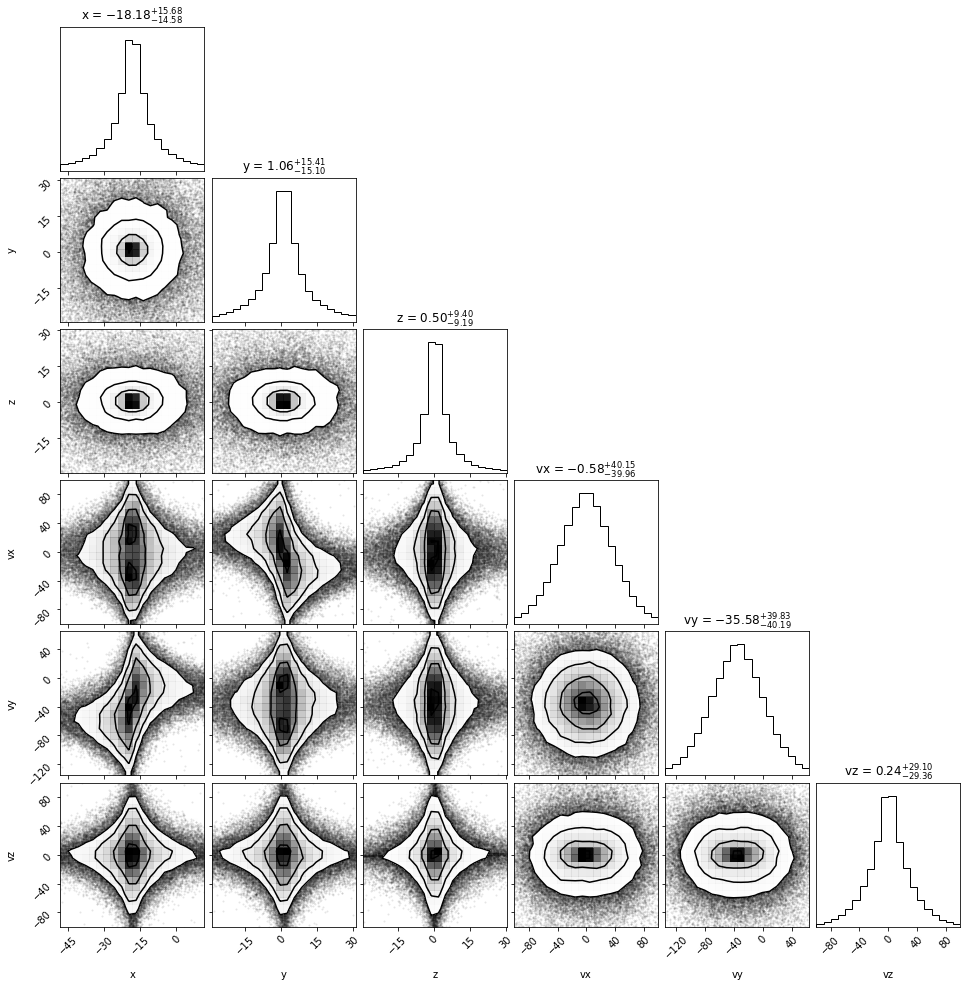

In [11]:
# corner figure of data set 

fig = corner.corner(df.loc[df.star==True][['x','y','z','vx','vy','vz']], range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Generate a new, synthetic dataset that follows the same underlying distibution as the original dataset:

In [12]:
# stack our original data into the format that is expected by gaussian_kde

orig_data = np.vstack([df['x'].values, df['y'].values, df['z'].values, df['vx'].values, df['vy'].values, df['vz'].values])

In [13]:
# create the kde. bw_method = .001 value selected for best fit by eye. 

kde = gaussian_kde(orig_data, bw_method = .0001)

In [14]:
#resample the kde to create the synthetic dataset 

new_data = kde.resample(size=len(df['x'].values))

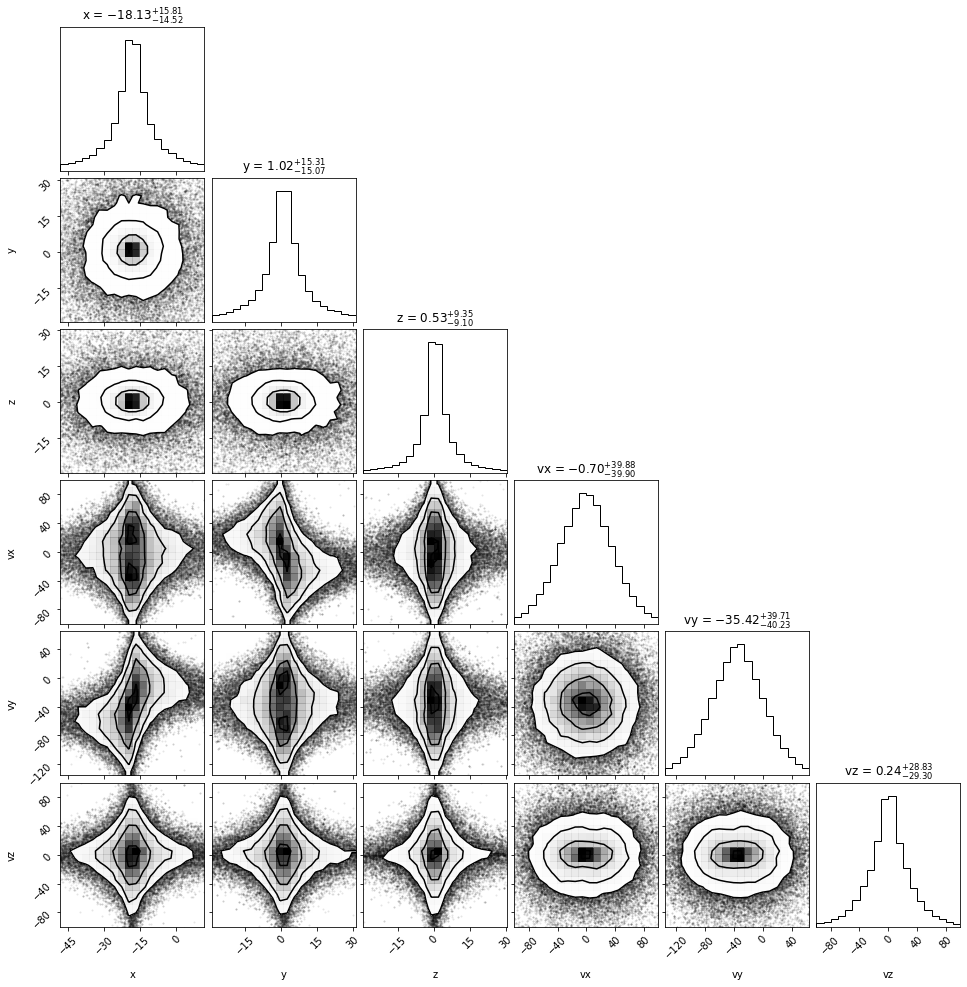

In [15]:
#corner plot using new synthetic data to mirror the one above 

fig = corner.corner(new_data.T, range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Determine and move to the black hole's center of mass (com) frame:

In [16]:
#data for the two black holes:
df_bh = df.loc[df["star"]==False].copy()
df_bh

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.20694,1.048421,0.377924,-288.6334,93.93971,9.444297,1000000.0,18.241016,303.682570,False,1
65537,-18.21712,1.028614,0.377476,285.5273,-172.52600,-12.315550,1000000.0,18.250041,333.830395,False,2


In [17]:
#black holes masses are the same in this dataset, so could just take the average
#but coding the full com caclculation for using this code on a non-equal mass dataset

#also note that this is not the center of mass of the cluster, it is the center of mass of the two black holes
#see commmented code block below for center of mass of entire cluster

x_bh_com = (df_bh.x*df_bh.m).sum() / df_bh.m.sum() 
y_bh_com = (df_bh.y*df_bh.m).sum() / df_bh.m.sum()
z_bh_com = (df_bh.z*df_bh.m).sum() / df_bh.m.sum()

vx_bh_com = (df_bh.vx*df_bh.m).sum() / df_bh.m.sum() 
vy_bh_com = (df_bh.vy*df_bh.m).sum() / df_bh.m.sum()
vz_bh_com = (df_bh.vz*df_bh.m).sum() / df_bh.m.sum()

In [18]:
# #example code for center of mass of entire cluster or each individual cluster:

# #calculate the total center of mass:
# xcom = (df.x*df.m).sum() / df.m.sum()

# #center of mass of each cluster
# xcom1 = (df.loc[df['nsc'] == 1].x*df.loc[df['nsc'] == 1].m).sum() / df.loc[df['nsc'] == 1].m.sum()
# xcom2 = (df.loc[df['nsc'] == 2].x*df.loc[df['nsc'] == 2].m).sum() / df.loc[df['nsc'] == 2].m.sum()

In [19]:
#create a data frame moved the the black hole's center of mass frame

df_com = df.copy()
df_com['x'] = df_com['x'] - x_bh_com
df_com['y'] = df_com['y'] - y_bh_com
df_com['z'] = df_com['z'] - z_bh_com
df_com['vx'] = df_com['vx'] - vx_bh_com
df_com['vy'] = df_com['vy'] - vy_bh_com
df_com['vz'] = df_com['vz'] - vz_bh_com

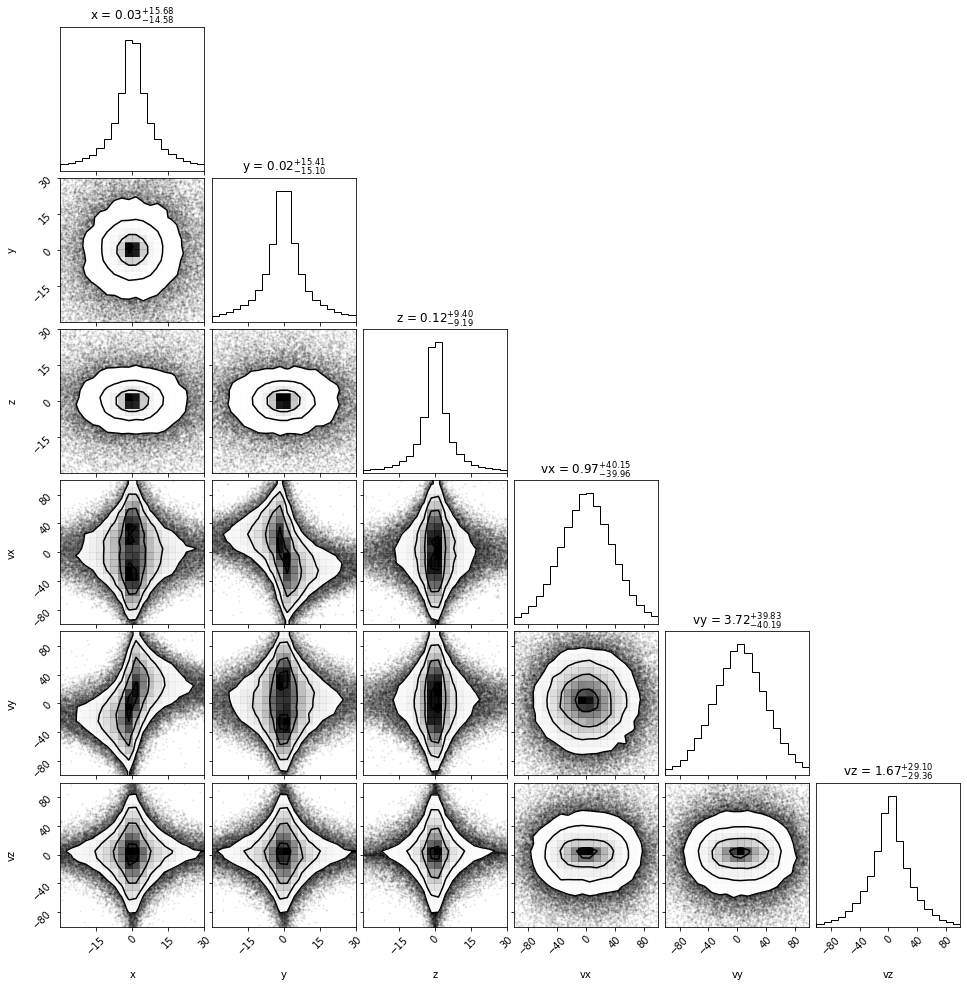

In [20]:
#new corner plot with com data
#note that median has been removed in range definition 

fig = corner.corner(df_com.loc[df_com.star==True][['x','y','z','vx','vy','vz']], range = [(-30,30),(-30,30), (-30,30), (-100,100), (-100,100), (-100,100)], labels=df_com.columns.tolist(), show_titles=True, title_fmt=".2f")
